Projet : Dubai Mall - Segmentation de la clientèle

Ce projet a pour objectif de segmenter la clientèle du Dubai Mall à l’aide de techniques de clustering (apprentissage non supervisé) afin de mieux comprendre les comportements d’achat et de proposer des stratégies marketing ciblées.

Le jeu de données utilisé contient des informations démographiques et comportementales sur les clients, notamment :

le sexe, l’âge, le revenu annuel, le score de dépense.
Ces variables permettent de capturer :
- La dimension démographique
- La capacité financière
- Le comportement d’achat


Inspection initiale

In [2]:
# Importation des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import (
shapiro, normaltest,
spearmanr, pearsonr,
mannwhitneyu, ttest_ind,
chi2_contingency, skew, kurtosis
)
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

In [3]:
#Importation de notre jeu de donnée et apercu des 5 premières lignes
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
#Suppression de la variable (Custumer ID)
df = df.drop(columns="CustomerID")

In [6]:
df.describe()

,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


Clustering

Avant d’appliquer le clustering, on doit : rendre les variables comparables entre elles, transformer les variables catégorielles, éviter que certaines variables dominent artificiellement les autres. 

In [7]:
# =========================
#  Préparation des données pour le clustering (séparation des features, normalisation des variables numériques et encodage de la variable catégorielle)
# (pas de variable cible)
# =========================
X = df.copy()

numeric_features = X.select_dtypes(include='number').columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(drop="first"), categorical_features)
])

Les données ont été prétraitées afin de garantir la compatibilité avec les modeles de clustering. La variable catégorielle Gender a été encodée numériquement, et les variables quantitatives ont été standardisées afin d’éviter tout biais lié aux différences d’échelle. Le jeu de données final est ainsi prêt pour l’application des méthodes de segmentation.

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Wi

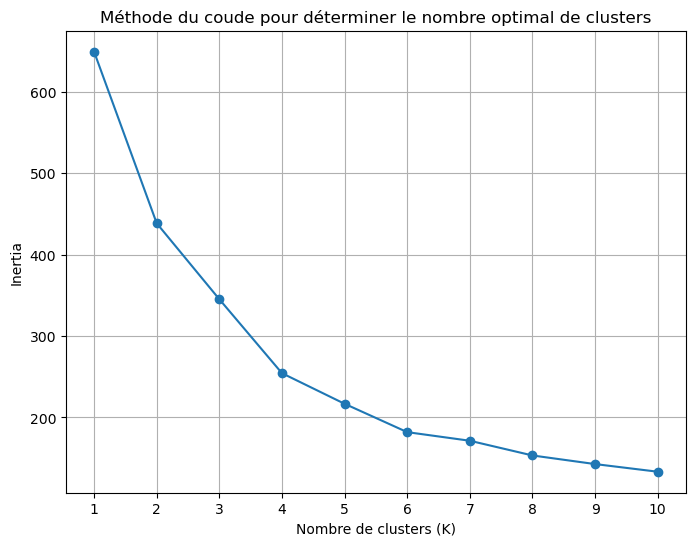

In [8]:
#Détermination du nombre optimal de clusters par la methode des courdes
# =========================
# Méthode du coude (choix de K)
# =========================
X_prepared = preprocessor.fit_transform(X)

inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_prepared)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel("Nombre de clusters (K)")
plt.ylabel("Inertia")
plt.title("Méthode du coude pour déterminer le nombre optimal de clusters")
plt.xticks(K_range)
plt.grid(True)
plt.show()

Commentaire : Forte baisse de l’inertie entre k=1 et k≈4/5.
Puis la courbe s’aplatit. k = 4 est généralement selon nous un très bon nombre pour le nombre optimal de clusters. 

1-K-means

In [9]:
# =========================
# Clustering avec K-Means (entrainement du model et affichage de la nouvelle colonne "cluster" dans notre dataset original)
# =========================
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, random_state=42, n_init = 10)
df["cluster"] = kmeans.fit_predict(X_prepared)

df.head

c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<bound method NDFrame.head of      Gender  Age  Annual Income (k$)  Spending Score (1-100)  cluster
0      Male   19                  15                      39        1
1      Male   21                  15                      81        1
2    Female   20                  16                       6        1
3    Female   23                  16                      77        1
4    Female   31                  17                      40        1
..      ...  ...                 ...                     ...      ...
195  Female   35                 120                      79        0
196  Female   45                 126                      28        2
197    Male   32                 126                      74        0
198    Male   32                 137                      18        2
199    Male   30                 137                      83        0

[200 rows x 5 columns]>

In [10]:
#Analyse et interpretation des clusters
#Plofil de chaque cluster (moyennes par cluster)
cluster_profile = (
    df
    .groupby("cluster")
    .agg({
        "Age": "mean",
        "Annual Income (k$)": "mean",
        "Spending Score (1-100)": "mean",
        "Gender": lambda x: x.value_counts().idxmax()
    })
)
# Ajouter la taille de chaque cluster
cluster_profile["cluster Size"] = df["cluster"].value_counts().sort_index().values
cluster_profile

,Age,Annual Income (k$),Spending Score (1-100),Gender,cluster Size
cluster,,,,,
0,32.875000,86.100000,81.525000,Female,40
1,25.438596,40.000000,60.298246,Female,57
2,39.368421,86.500000,19.578947,Female,38
3,53.984615,47.707692,39.969231,Female,65


Commentaire : 
Interpretation des clusters

    - Cluster 3 – Clients à faible valeur de d'achat
Revenu : faible
Spending Score : faible
Taille : importante
    -  Stratégie
Promotions
Offres à prix réduits
Objectif : augmenter la fréquence de visite

    - Cluster 1 – Clients impulsifs
Revenu : faible à moyen
Spending Score : élevé
Souvent plus jeunes
    - Stratégie
Marketing digital
Offres événementielles
Fidélisation rapide

    - Cluster 2 – Clients à fort potentiel
Revenu : élevé
Spending Score : faible
    - Stratégie
Offres personnalisées
Expériences premium
Inciter à la dépense

    - Cluster 3 – Clients VIP
Revenu : élevé
Spending Score : élevé
Taille plus réduite
    - Stratégie
Services exclusifs
Programmes VIP
Rétention maximale

In [11]:
# Recuperation des centres kmeans
y_kmeans = kmeans.labels_
centers = kmeans.cluster_centers_
centers

array([[-0.42880597,  0.97484722,  1.21608539,  0.45      ],
       [-0.96249203, -0.78476346,  0.39202966,  0.40350877],
       [ 0.03720536,  0.99011499, -1.18875705,  0.5       ],
       [ 1.08616125, -0.49056525, -0.39717443,  0.43076923]])

In [12]:
y_kmeans

array([1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 3, 1, 1, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1,
       3, 1, 3, 1, 1, 1, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 3, 1,
       3, 3, 1, 1, 3, 3, 3, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1, 3, 3, 1,
       1, 3, 3, 1, 3, 3, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 3, 1, 3, 3, 3, 3,
       3, 1, 2, 1, 1, 1, 3, 3, 3, 3, 1, 2, 0, 0, 2, 0, 2, 0, 3, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 3, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 2, 0,
       2, 0], dtype=int32)

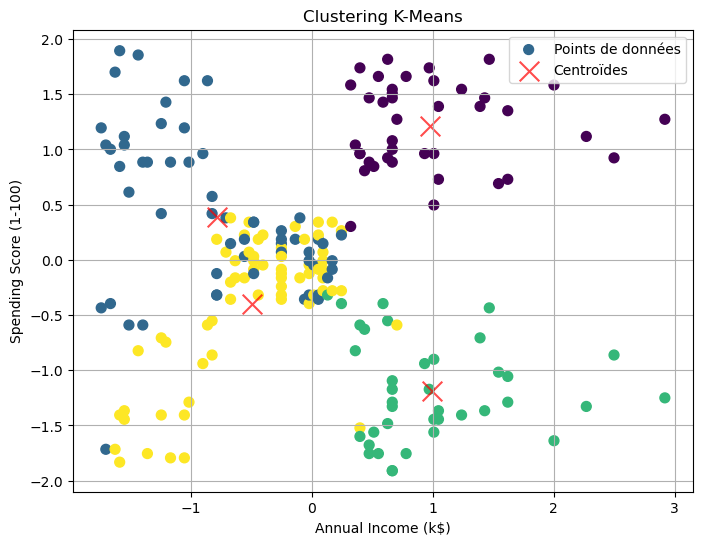

Centroïdes finaux: 
[[-0.42880597  0.97484722  1.21608539  0.45      ]
 [-0.96249203 -0.78476346  0.39202966  0.40350877]
 [ 0.03720536  0.99011499 -1.18875705  0.5       ]
 [ 1.08616125 -0.49056525 -0.39717443  0.43076923]]


In [13]:
# visualisation des clusters
plt.figure(figsize=(8, 6))
plt.scatter(X_prepared[:, 1], X_prepared[:, 2], c=y_kmeans, s=50, cmap='viridis', label='Points de données')
plt.scatter(centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.7, marker='x', label='Centroïdes')
plt.title('Clustering K-Means')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()
print(f"Centroïdes finaux: \n{centers}")

Conclusion: Ce projet a permis de segmenter la clientèle du Dubai Mall à l’aide de techniques de Kmeans.
L’analyse exploratoire et les méthodes de validation ont conduit à une segmentation en quatre groupes distincts, chacun présentant des comportements d’achat spécifiques.
Cette segmentation fournit une base solide pour la mise en place de stratégies marketing ciblées et l’amélioration de l’expérience client.

2-Clustering hiérarchique

In [14]:
#On utilise les memes données prétraités que pour K-Means
#importation du bibliothèque linkage
from scipy.cluster.hierarchy import linkage

Z = linkage(X_prepared, method="ward")



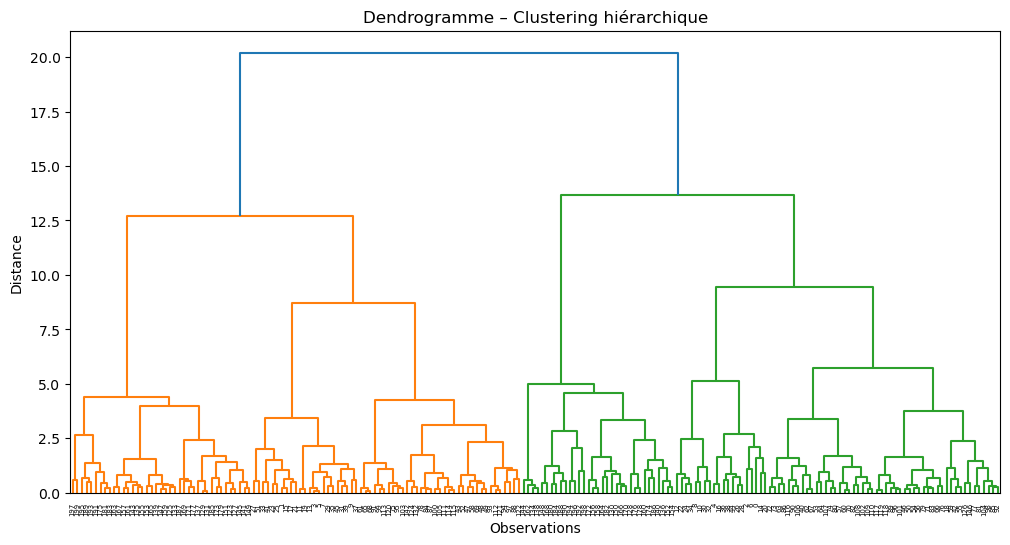

In [15]:
#Visualisation du dendrogramme
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
dendrogram(Z)
plt.title("Dendrogramme – Clustering hiérarchique")
plt.xlabel("Observations")
plt.ylabel("Distance")
plt.show()


Commentaire : Le dendrogramme met en évidence une structure hiérarchique claire des données.
Une séparation majeure apparaît à une distance élevée (entre 15 et 17.5), suggérant l’existence de deux grands groupes distincts.
Une coupure à une distance intermédiaire permet d’identifier quatre clusters bien séparés (distance entre 10 et 12.5), représentant un bon compromis entre homogénéité intra-cluster et séparation inter-cluster. Ce qui confirme le choix de k = 4 retenu avec K-Means.

In [16]:
# Découpage du clustering hiérachique en k=4 (4 clusters)
from scipy.cluster.hierarchy import fcluster

df["Cluster_Hierarchical"] = fcluster(Z, t=4, criterion="maxclust")


In [17]:
# Taille des clusters hiérarchiques
df["Cluster_Hierarchical"].value_counts().sort_index()

Cluster_Hierarchical
1    39
2    58
3    33
4    70
Name: count, dtype: int64

In [18]:
# les profils moyens
df.groupby("Cluster_Hierarchical").mean(numeric_only=True)

,Age,Annual Income (k$),Spending Score (1-100),cluster
Cluster_Hierarchical,,,,
1,32.692308,86.538462,82.128205,0.000000
2,25.931034,45.017241,60.517241,1.103448
3,41.454545,89.090909,16.181818,2.060606
4,51.757143,45.514286,39.900000,2.800000


Le clustering hiérarchique a été utilisé comme méthode de validation.
L’analyse du dendrogramme met en évidence quatre groupes distincts, confirmant le nombre de clusters retenu avec K-Means.
Les profils obtenus sont cohérents entre les deux méthodes, renforçant la robustesse de la segmentation.

3-GMM (Gaussian Mixture Models)

In [19]:
# Importation de GaussianMixture
from sklearn.mixture import GaussianMixture

In [20]:
#Choix du nombre de clusters
#Pour rester cohérent avec tes résultats précédents : on a utilise k = 4
gmm = GaussianMixture(
    n_components=4,
    random_state=42
)

In [21]:
#entrainement et prédiction
gmm_G = gmm.fit_predict(X_prepared)

df["Cluster_GMM"] = gmm_G


c:\Users\LENOVO\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [22]:
# Recuperation des centres GMM
centers_gmm = gmm.means_

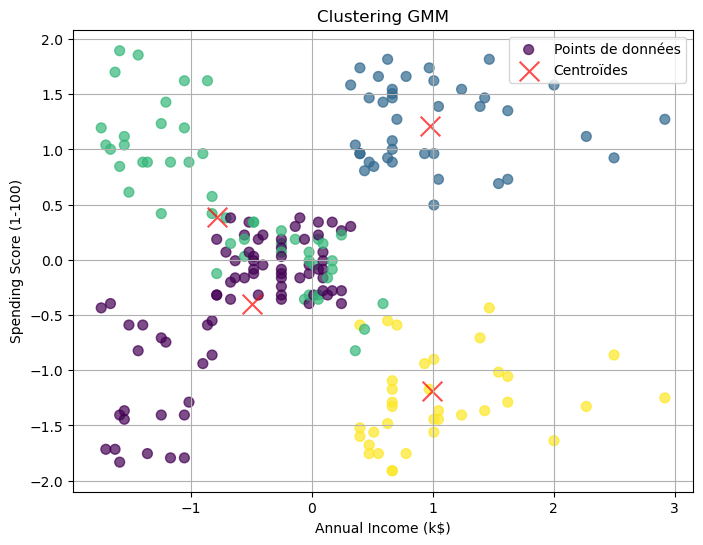

Centroïdes finaux GMM : 
[[-0.42880597  0.97484722  1.21608539  0.45      ]
 [-0.96249203 -0.78476346  0.39202966  0.40350877]
 [ 0.03720536  0.99011499 -1.18875705  0.5       ]
 [ 1.08616125 -0.49056525 -0.39717443  0.43076923]]


In [23]:
#Vilsualisation des clusters
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(X_prepared[:, 1], X_prepared[:, 2], c=gmm_G, s=50, cmap='viridis', alpha = 0.7, label='Points de données')
plt.scatter(centers[:, 1], centers[:, 2], c='red', s=200, alpha=0.7, marker='x',
label='Centroïdes')
plt.title('Clustering GMM')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.legend()
plt.grid(True)
plt.show()
print(f"Centroïdes finaux GMM : \n{centers}")

Commentaire :
La visualisation a permi d'obtenir 4 clusters proche à celui obtenir durant la methode de Kmeans.

In [24]:
#Analyse des clusters
# profils moyens des clusters
df.groupby("Cluster_GMM").mean(numeric_only=True)


,Age,Annual Income (k$),Spending Score (1-100),cluster,Cluster_Hierarchical
Cluster_GMM,,,,,
0,50.184211,45.842105,40.697368,2.671053,3.789474
1,32.692308,86.538462,82.128205,0.000000,1.000000
2,24.440000,43.300000,62.780000,1.060000,2.000000
3,41.685714,88.228571,17.285714,2.057143,3.057143


In [25]:
# taille des clusters
df["Cluster_GMM"].value_counts().sort_index()

Cluster_GMM
0    76
1    39
2    50
3    35
Name: count, dtype: int64

Plusieurs méthodes de clustering ont été explorées afin d’analyser la robustesse de la segmentation. Les approches basées sur les distances (K-Means), hiérarchiques et probabilistes (GMM) ont permis d’identifier 4 segments interprétables, confirmant la structure sous-jacente de la clientèle du Dubai Mall.

4-DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [27]:
# Importation de DBSCAN
from sklearn.cluster import DBSCAN


In [28]:
# Premier test (valeurs classiques)
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_prepared)

df["Cluster_DBSCAN"] = dbscan_labels


In [29]:
# Nombre de clusters trouvés
set(dbscan_labels)

{np.int64(-1),
 np.int64(0),
 np.int64(1),
 np.int64(2),
 np.int64(3),
 np.int64(4),
 np.int64(5),
 np.int64(6),
 np.int64(7),
 np.int64(8)}

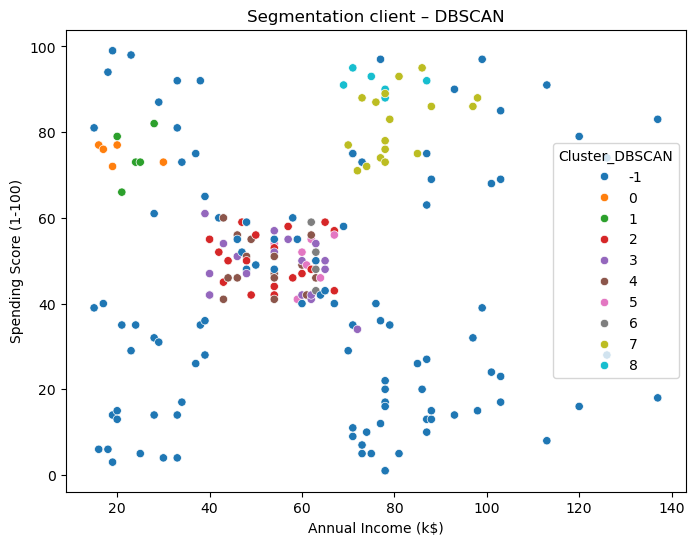

In [30]:
# Visualisation des clusters
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster_DBSCAN",
    palette="tab10"
)
plt.title("Segmentation client – DBSCAN")
plt.show()


In [31]:
# profils moyens des clusters
df.groupby("Cluster_DBSCAN").mean(numeric_only=True)

,Age,Annual Income (k$),Spending Score (1-100),cluster,Cluster_Hierarchical,Cluster_GMM
Cluster_DBSCAN,,,,,,
-1,39.314286,63.580952,40.847619,1.723810,2.790476,1.495238
0,24.000000,20.400000,75.000000,1.000000,2.000000,2.000000
1,25.400000,23.600000,74.600000,1.000000,2.000000,2.000000
2,49.722222,53.388889,50.333333,3.000000,4.000000,0.000000
3,25.444444,53.888889,48.277778,1.055556,2.000000,1.666667
4,57.400000,52.066667,48.866667,3.000000,4.000000,0.000000
5,22.857143,61.000000,50.428571,1.000000,2.000000,2.000000
6,66.500000,62.750000,50.500000,3.000000,4.000000,0.000000
7,31.470588,80.470588,81.823529,0.000000,1.000000,1.000000


In [32]:
# Taille des clusters
df["Cluster_DBSCAN"].value_counts()


Cluster_DBSCAN
-1    105
 3     18
 2     18
 7     17
 4     15
 5      7
 8      6
 0      5
 1      5
 6      4
Name: count, dtype: int64

Commentaire :
La méthode DBSCAN a été expérimentée afin d’explorer une approche basée sur la densité.
Toutefois, en raison de la distribution relativement homogène des données et de l’absence de zones de forte densité bien distinctes, DBSCAN n’a pas permis d’identifier des segments clients aussi exploitables que les autres méthodes. Cette observation confirme que DBSCAN est moins adaptée à la structure de notre jeu de données.

Methode choisie:
Parmi les méthodes expérimentées, le clustering hiérarchique et K-Means ont fourni les segmentations les plus cohérentes et interprétables. Le choix de la méthode K-Means s’explique par sa simplicité, son efficacité et sa forte interprétabilité dans un contexte de segmentation client.
Les données du Dubai Mall présentent une structure favorable à cette approche, avec des variables numériques bien normalisées et des groupes naturellement compacts.

Conclusion générale : 
Ce projet avait pour objectif de segmenter la clientèle du Dubai Mall à l’aide de techniques de clustering non supervisées.
Après une analyse exploratoire approfondie et un prétraitement adapté des données, plusieurs méthodes de clustering ont été mises en œuvre, notamment K-Means, le clustering hiérarchique, les modèles de mélanges gaussiens (le GMM) et DBSCAN.
Les résultats ont permis d’identifier des segments clients distincts et interprétables, caractérisés par des comportements d’achat et des niveaux de valeur différents.
Ces segments offrent une base solide pour la mise en place de stratégies marketing ciblées visant à améliorer la satisfaction client et à optimiser la performance commerciale du centre commercial.
Enfin, cette étude montre que le choix d’une méthode de clustering doit être guidé à la fois par la structure des données et par les objectifs métier.